In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import yfinance as yf
import pandas as pd
import numpy as np, random, os
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)
random.seed(42)
os.environ["PYTHONHASHSEED"] = "42"
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

etf_pairs = [('VO','IWB'), 
         ('VO','SPY'), 
         ('VO','SCHX'), 
         ('VO','SPLG'), 
         ('VO', 'IVV'),
         ('VO', 'VOO'), 
         ('DVY','IWR'), 
         ('SCHV', 'SPHQ'), 
         ('IWR','DIA'), 
         ('DVY','OEF'), 
         ('VTV', 'SPHQ'), 
         ('RSP', 'DIA'), 
         ('VO', 'DIA'), 
         ('DVY', 'FVD'), 
         ('DVY','VYM')] # closing

training_data = pd.read_csv("etf_train_prices.csv", index_col = 0, parse_dates = True)
testing_data = pd.read_csv("etf_test_prices.csv", index_col = 0, parse_dates = True)

In [2]:
def zscore_calc_test(series, mean, std):
    return (series - mean) / std

def zscore_calc_train(series):
    return (series - series.mean()) / series.std(), series.mean(), series.std()

def rolling_zscore(series, window = 60):
    mean = series.rolling(window).mean()
    std = series.rolling(window).std()
    return (series - mean) / std

def predict_mean_reversion_label(
    spread,
    z_window = 60,
    horizon = 10,
    entry_z = 1.0,
    min_pnl = 0.0,
):

    z = rolling_zscore(spread, window=z_window)

    direction = -np.sign(z)

    future_spread = spread.shift(-horizon)

    spread_change = future_spread - spread
    pnl = direction * spread_change

    cond_entry = z.abs() >= entry_z

    labels = ((cond_entry) & (pnl > min_pnl)).astype(float)

    labels = labels.iloc[:-horizon]

    labels = labels.dropna()

    return labels

def create_features(spread, window):
    df = pd.DataFrame({'spread': spread})

    df['z-score'] = rolling_zscore(df['spread'])

    df['z-score_lag1'] = df['z-score'].shift(1)
    df['spread_lag1'] = df['spread'].shift(1)
    df['rolling_mean'] = df['spread'].rolling(window).mean()
    df['volatility'] = df['spread'].pct_change().rolling(window).std()
    df['z-score_lag2'] = df['z-score'].shift(2)
    df['z-score_lag5'] = df['z-score'].shift(5)

    df = df.dropna()
    return df

training_spreads = {}
testing_spreads = {}

X_train_dict = {}
y_train_dict = {}
X_test_dict = {}
y_test_dict = {}

window = 5

for etf1, etf2 in etf_pairs:

    pair_name = f'{etf1}_{etf2}'

    train_z1, mean_z1, std_z1 = zscore_calc_train(training_data[etf1])
    train_z2, mean_z2, std_z2 = zscore_calc_train(training_data[etf2])

    test_z1 = zscore_calc_test(testing_data[etf1], mean_z1, std_z1)
    test_z2 = zscore_calc_test(testing_data[etf2], mean_z2, std_z2)

    training_spread, testing_spread = train_z1 - train_z2, test_z1 - test_z2
    training_spreads[pair_name], testing_spreads[pair_name] = training_spread, testing_spread

    train_features = create_features(training_spread, window = window)
    test_features  = create_features(testing_spread, window = window)

    train_labels = predict_mean_reversion_label(
        training_spread,
        z_window = 60,
        horizon = 10,
        entry_z = 1.0,
        min_pnl = 0.0,
    )

    test_labels = predict_mean_reversion_label(
        testing_spread,
        z_window = 60,
        horizon = 10,
        entry_z = 1.0,
        min_pnl = 0.0,
    )

    train_idx = train_features.index.intersection(train_labels.index)
    test_idx  = test_features.index.intersection(test_labels.index)

    train_features = train_features.loc[train_idx].copy()
    test_features  = test_features.loc[test_idx].copy()

    train_labels = train_labels.loc[train_idx]
    test_labels  = test_labels.loc[test_idx]

    train_features['label'] = train_labels
    test_features['label']  = test_labels

    train_features = train_features.dropna(subset=['label'])
    test_features  = test_features.dropna(subset=['label'])

    X_train_dict[pair_name] = train_features.drop(columns=['label'])
    y_train_dict[pair_name] = train_features['label']
    X_test_dict[pair_name]  = test_features.drop(columns=['label'])
    y_test_dict[pair_name]  = test_features['label']

for pair_name in y_train_dict:
    print(pair_name, 
          "train_label_mean:", y_train_dict[pair_name].mean(), 
          "test_label_mean:",  y_test_dict[pair_name].mean())

training_spreads_df = pd.DataFrame(training_spreads)
testing_spreads_df = pd.DataFrame(testing_spreads)

VO_IWB train_label_mean: 0.2939189189189189 test_label_mean: 0.27218934911242604
VO_SPY train_label_mean: 0.29307432432432434 test_label_mean: 0.27303465765004226
VO_SCHX train_label_mean: 0.2947635135135135 test_label_mean: 0.2704987320371936
VO_SPLG train_label_mean: 0.29138513513513514 test_label_mean: 0.2688081149619611
VO_IVV train_label_mean: 0.2922297297297297 test_label_mean: 0.2704987320371936
VO_VOO train_label_mean: 0.2981418918918919 test_label_mean: 0.2713440405748098
DVY_IWR train_label_mean: 0.3015202702702703 test_label_mean: 0.28233305156382077
SCHV_SPHQ train_label_mean: 0.2829391891891892 test_label_mean: 0.28233305156382077
IWR_DIA train_label_mean: 0.2846283783783784 test_label_mean: 0.28317836010143704
DVY_OEF train_label_mean: 0.31841216216216217 test_label_mean: 0.2781065088757396
VTV_SPHQ train_label_mean: 0.2635135135135135 test_label_mean: 0.28402366863905326
RSP_DIA train_label_mean: 0.2972972972972973 test_label_mean: 0.2764158918005072
VO_DIA train_label_m

In [3]:
def create_sequences(X, y, window_size):
    X_seq, y_seq  = [], []

    for i in range(len(X) - window_size):
        X_seq.append(X.iloc[i : i + window_size].values)
        y_seq.append(y.iloc[i + window_size])

    return np.array(X_seq), np.array(y_seq)

In [4]:
class ClassificationLSTM(nn.Module):
    def __init__(self, hidden_size, num_layers, input_size):
        super(ClassificationLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
        self.linear = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.linear(out)
        return out.squeeze()

In [5]:
def train_model(model, train_loader, criterion, optimizer, epochs = 30, device = 'cpu'):
    model.train()
    
    for epoch in range(epochs):
        total_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss / len(train_loader):.4f}")

In [6]:
def evaluate_model(model, pair_name, test_loader, device = 'cpu'):
    model.eval()
    all_preds = []
    all_true = []

    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            preds = torch.sigmoid(logits)
            all_preds.append(preds.cpu())
            all_true.append(yb.cpu())
    y_pred = torch.cat(all_preds).numpy()
    y_true = torch.cat(all_true).numpy()
    y_pred_label = (y_pred > 0.5).astype(int)
    accuracy = accuracy_score(y_true, y_pred_label)
    print("Test Accuracy: ", accuracy)
    return y_true, y_pred, y_pred_label

In [7]:
def plot_labels(X_df, y_pred_label, pair_name):
    spread = X_df['spread']
    
    aligned_spread = spread[-len(y_pred_label):]
    predicted_points = aligned_spread[y_pred_label == 1]

    plt.figure(figsize=(12, 5))
    sns.lineplot(x = aligned_spread.index, y = aligned_spread.values, label = 'Spread', color = 'black')
    sns.scatterplot(x = predicted_points.index, y = predicted_points.values, color = 'green', label = 'Predicted Reversion', s = 100, marker = 'o')
    plt.title(f"Predicted Mean Reversions of {pair_name}")
    plt.xlabel("Date")
    plt.ylabel("Spread")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [8]:
def print_confusion_matrix(y_true, y_pred_label):
    cm = confusion_matrix(y_true, y_pred_label, labels = [0, 1])
    print("Confusion Matrix:")
    print(cm)

In [9]:
def print_f1(y_true, y_pred_label):
    f1 = f1_score(y_true, y_pred_label)
    print(f"F1 Score: {f1:.4f}")

In [10]:
def run_pair(pair_name, X_train_dict, y_train_dict, X_test_dict, y_test_dict, epochs, device = 'cpu'):

    hidden_size = 32
    lr = 0.01
    num_layers = 1
    window_size = 5
    batch_size = 32

    X_df = X_train_dict[pair_name]
    y_series = y_train_dict[pair_name]

    X_seq, y_seq = create_sequences(X_df, y_series, window_size = window_size)

    X_train = torch.tensor(X_seq, dtype = torch.float32)
    y_train = torch.tensor(y_seq, dtype = torch.float32).unsqueeze(-1)

    pos_weight = torch.tensor([(len(y_train) - y_train.sum()) / y_train.sum()]).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight = pos_weight)

    X_test_df = X_test_dict[pair_name]
    y_test_series = y_test_dict[pair_name]

    X_test_seq, y_test_seq = create_sequences(X_test_df, y_test_series, window_size = window_size)
    
    X_test = torch.tensor(X_test_seq, dtype = torch.float32)
    y_test = torch.tensor(y_test_seq, dtype = torch.float32).unsqueeze(-1)
    
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = False)
    test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)
    
    model = ClassificationLSTM(input_size = 8, hidden_size = hidden_size, num_layers = num_layers).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    
    print(f"\nTraining model for pair: {pair_name}")
    train_model(model, train_loader, criterion, optimizer, epochs = epochs, device = device)
    
    print(f"\nEvaluating model for pair: {pair_name}")
    y_true, y_pred, y_pred_label = evaluate_model(model, pair_name, test_loader, device = device)

    plot_labels(X_test_df, y_pred_label, pair_name)

    print_confusion_matrix(y_true, y_pred_label)

    print_f1(y_true, y_pred_label)
    
    return model, y_true, y_pred


Training model for pair: VO_IWB
Epoch 1/20 - Loss: 0.9588
Epoch 2/20 - Loss: 0.8985
Epoch 3/20 - Loss: 0.8571
Epoch 4/20 - Loss: 0.8326
Epoch 5/20 - Loss: 0.8132
Epoch 6/20 - Loss: 0.7974
Epoch 7/20 - Loss: 0.7759
Epoch 8/20 - Loss: 0.7529
Epoch 9/20 - Loss: 0.7352
Epoch 10/20 - Loss: 0.7196
Epoch 11/20 - Loss: 0.7043
Epoch 12/20 - Loss: 0.6906
Epoch 13/20 - Loss: 0.6707
Epoch 14/20 - Loss: 0.6871
Epoch 15/20 - Loss: 0.6708
Epoch 16/20 - Loss: 0.6568
Epoch 17/20 - Loss: 0.6391
Epoch 18/20 - Loss: 0.6078
Epoch 19/20 - Loss: 0.5714
Epoch 20/20 - Loss: 0.5492

Evaluating model for pair: VO_IWB
Test Accuracy:  0.6910016977928692


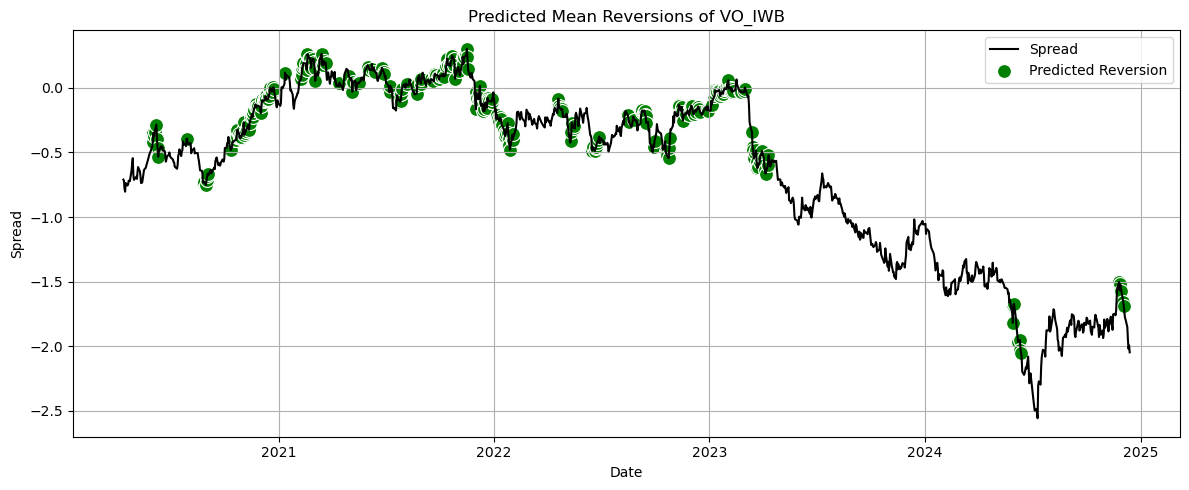

Confusion Matrix:
[[682 177]
 [187 132]]
F1 Score: 0.4204

Training model for pair: VO_SPY
Epoch 1/20 - Loss: 0.9704
Epoch 2/20 - Loss: 0.9063
Epoch 3/20 - Loss: 0.8613
Epoch 4/20 - Loss: 0.8229
Epoch 5/20 - Loss: 0.8104
Epoch 6/20 - Loss: 0.7891
Epoch 7/20 - Loss: 0.7702
Epoch 8/20 - Loss: 0.7598
Epoch 9/20 - Loss: 0.7548
Epoch 10/20 - Loss: 0.7428
Epoch 11/20 - Loss: 0.7243
Epoch 12/20 - Loss: 0.7194
Epoch 13/20 - Loss: 0.7045
Epoch 14/20 - Loss: 0.7089
Epoch 15/20 - Loss: 0.6769
Epoch 16/20 - Loss: 0.6543
Epoch 17/20 - Loss: 0.6571
Epoch 18/20 - Loss: 0.6469
Epoch 19/20 - Loss: 0.6265
Epoch 20/20 - Loss: 0.6276

Evaluating model for pair: VO_SPY
Test Accuracy:  0.7054329371816639


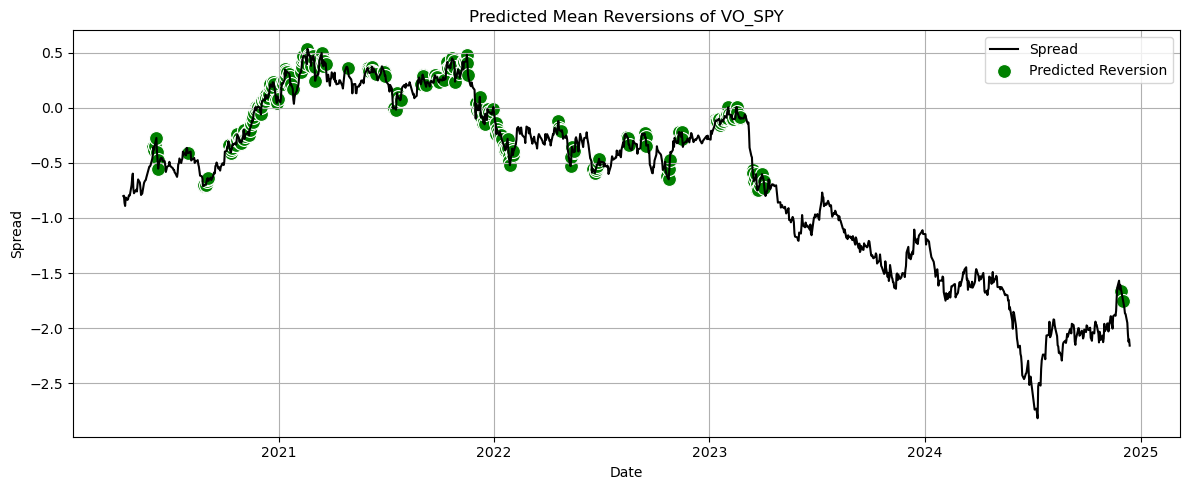

Confusion Matrix:
[[708 150]
 [197 123]]
F1 Score: 0.4148

Training model for pair: VO_SCHX
Epoch 1/20 - Loss: 0.9689
Epoch 2/20 - Loss: 0.9113
Epoch 3/20 - Loss: 0.8778
Epoch 4/20 - Loss: 0.8395
Epoch 5/20 - Loss: 0.8133
Epoch 6/20 - Loss: 0.7869
Epoch 7/20 - Loss: 0.7749
Epoch 8/20 - Loss: 0.7622
Epoch 9/20 - Loss: 0.7669
Epoch 10/20 - Loss: 0.7351
Epoch 11/20 - Loss: 0.7378
Epoch 12/20 - Loss: 0.7144
Epoch 13/20 - Loss: 0.6999
Epoch 14/20 - Loss: 0.6798
Epoch 15/20 - Loss: 0.6841
Epoch 16/20 - Loss: 0.6745
Epoch 17/20 - Loss: 0.6455
Epoch 18/20 - Loss: 0.6227
Epoch 19/20 - Loss: 0.6081
Epoch 20/20 - Loss: 0.6188

Evaluating model for pair: VO_SCHX
Test Accuracy:  0.7062818336162988


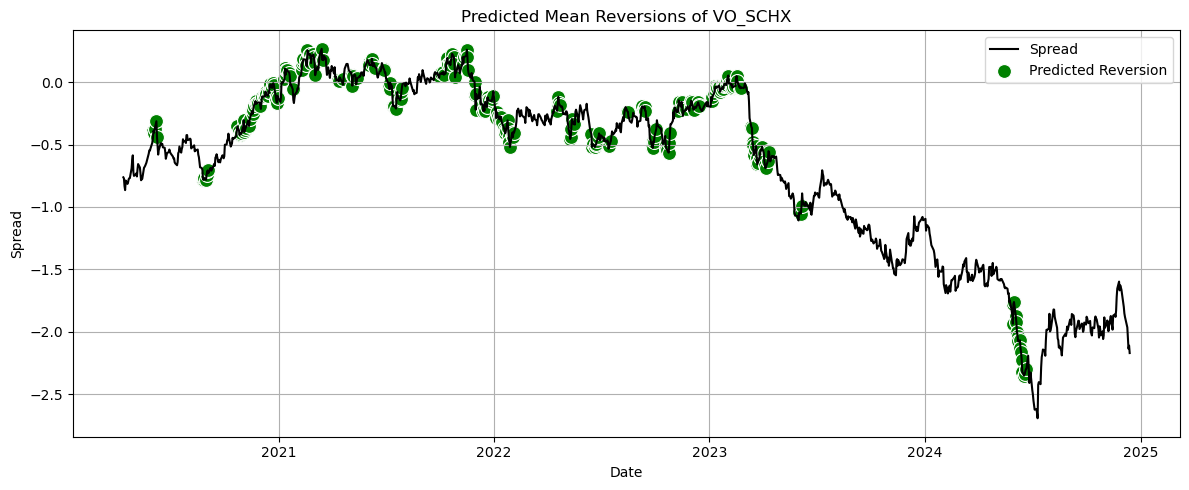

Confusion Matrix:
[[701 160]
 [186 131]]
F1 Score: 0.4309

Training model for pair: VO_SPLG
Epoch 1/20 - Loss: 0.9747
Epoch 2/20 - Loss: 0.9237
Epoch 3/20 - Loss: 0.8857
Epoch 4/20 - Loss: 0.8559
Epoch 5/20 - Loss: 0.8337
Epoch 6/20 - Loss: 0.8174
Epoch 7/20 - Loss: 0.7987
Epoch 8/20 - Loss: 0.7888
Epoch 9/20 - Loss: 0.7657
Epoch 10/20 - Loss: 0.7458
Epoch 11/20 - Loss: 0.7400
Epoch 12/20 - Loss: 0.7194
Epoch 13/20 - Loss: 0.7068
Epoch 14/20 - Loss: 0.6844
Epoch 15/20 - Loss: 0.6803
Epoch 16/20 - Loss: 0.6595
Epoch 17/20 - Loss: 0.6357
Epoch 18/20 - Loss: 0.5902
Epoch 19/20 - Loss: 0.5994
Epoch 20/20 - Loss: 0.5840

Evaluating model for pair: VO_SPLG
Test Accuracy:  0.6774193548387096


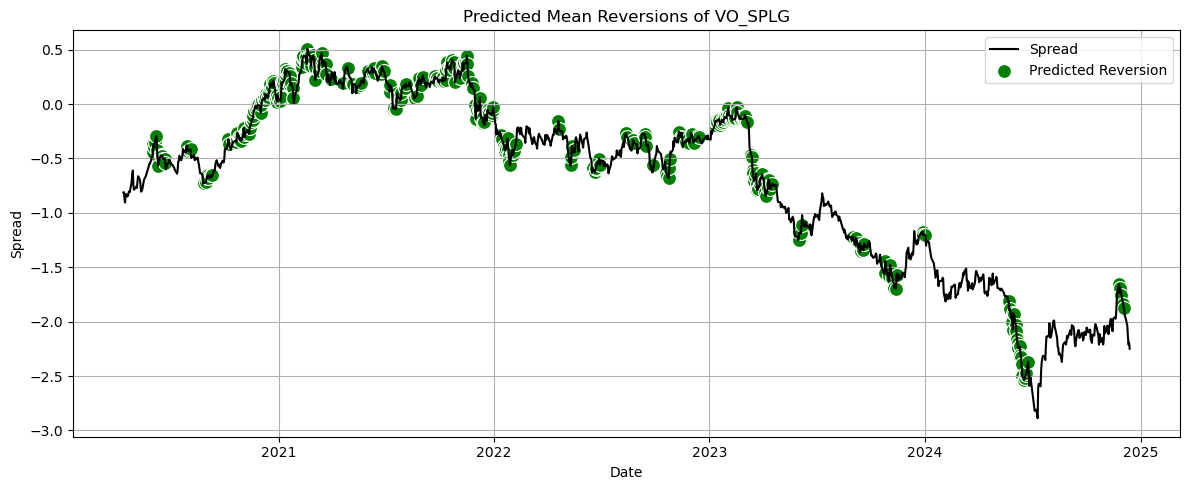

Confusion Matrix:
[[638 225]
 [155 160]]
F1 Score: 0.4571

Training model for pair: VO_IVV
Epoch 1/20 - Loss: 0.9696
Epoch 2/20 - Loss: 0.9035
Epoch 3/20 - Loss: 0.8628
Epoch 4/20 - Loss: 0.8346
Epoch 5/20 - Loss: 0.8086
Epoch 6/20 - Loss: 0.7891
Epoch 7/20 - Loss: 0.7717
Epoch 8/20 - Loss: 0.7690
Epoch 9/20 - Loss: 0.7549
Epoch 10/20 - Loss: 0.7356
Epoch 11/20 - Loss: 0.7213
Epoch 12/20 - Loss: 0.7121
Epoch 13/20 - Loss: 0.6964
Epoch 14/20 - Loss: 0.6875
Epoch 15/20 - Loss: 0.6852
Epoch 16/20 - Loss: 0.6879
Epoch 17/20 - Loss: 0.6469
Epoch 18/20 - Loss: 0.6337
Epoch 19/20 - Loss: 0.6300
Epoch 20/20 - Loss: 0.6137

Evaluating model for pair: VO_IVV
Test Accuracy:  0.7088285229202037


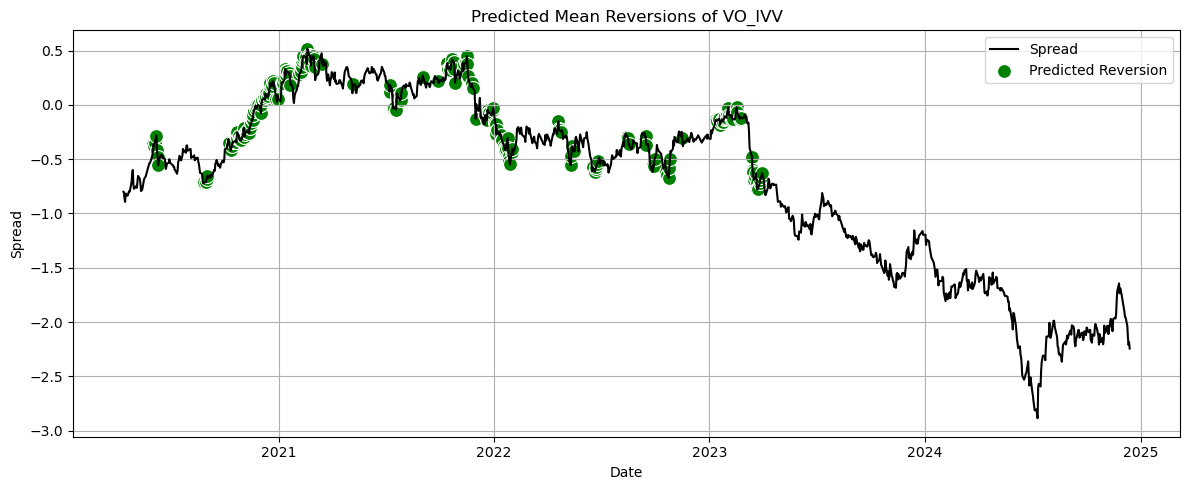

Confusion Matrix:
[[732 129]
 [214 103]]
F1 Score: 0.3752

Training model for pair: VO_VOO
Epoch 1/20 - Loss: 0.9565
Epoch 2/20 - Loss: 0.8860
Epoch 3/20 - Loss: 0.8502
Epoch 4/20 - Loss: 0.8233
Epoch 5/20 - Loss: 0.8001
Epoch 6/20 - Loss: 0.7971
Epoch 7/20 - Loss: 0.7738
Epoch 8/20 - Loss: 0.7632
Epoch 9/20 - Loss: 0.7553
Epoch 10/20 - Loss: 0.7331
Epoch 11/20 - Loss: 0.7089
Epoch 12/20 - Loss: 0.6970
Epoch 13/20 - Loss: 0.7379
Epoch 14/20 - Loss: 0.6939
Epoch 15/20 - Loss: 0.6763
Epoch 16/20 - Loss: 0.6626
Epoch 17/20 - Loss: 0.6448
Epoch 18/20 - Loss: 0.6309
Epoch 19/20 - Loss: 0.6452
Epoch 20/20 - Loss: 0.5828

Evaluating model for pair: VO_VOO
Test Accuracy:  0.7317487266553481


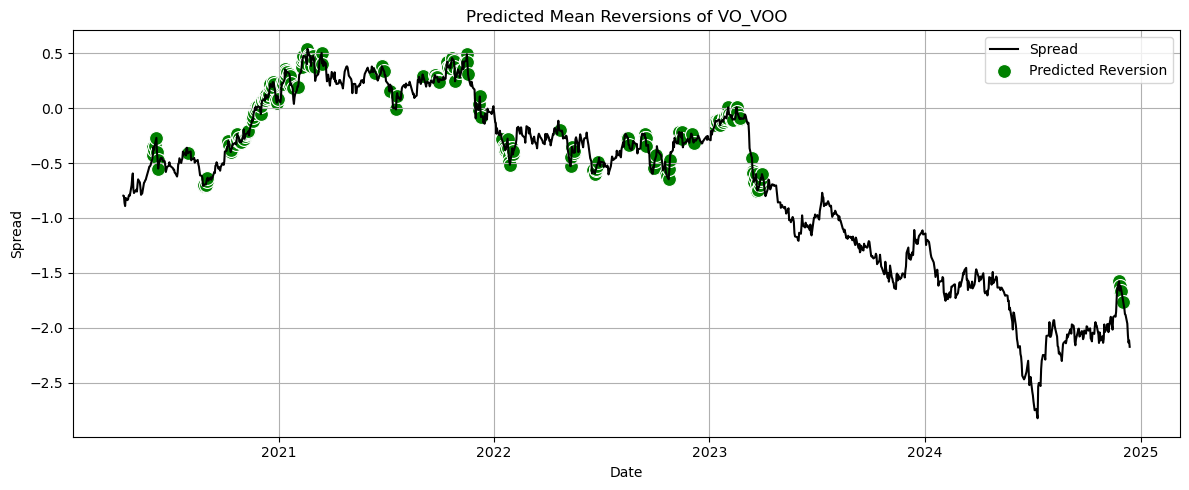

Confusion Matrix:
[[749 111]
 [205 113]]
F1 Score: 0.4170

Training model for pair: DVY_IWR
Epoch 1/20 - Loss: 0.9339
Epoch 2/20 - Loss: 0.8753
Epoch 3/20 - Loss: 0.8395
Epoch 4/20 - Loss: 0.8052
Epoch 5/20 - Loss: 0.7812
Epoch 6/20 - Loss: 0.7652
Epoch 7/20 - Loss: 0.7452
Epoch 8/20 - Loss: 0.7234
Epoch 9/20 - Loss: 0.6998
Epoch 10/20 - Loss: 0.7003
Epoch 11/20 - Loss: 0.6786
Epoch 12/20 - Loss: 0.6676
Epoch 13/20 - Loss: 0.6524
Epoch 14/20 - Loss: 0.6532
Epoch 15/20 - Loss: 0.6253
Epoch 16/20 - Loss: 0.6098
Epoch 17/20 - Loss: 0.6602
Epoch 18/20 - Loss: 0.6141
Epoch 19/20 - Loss: 0.6010
Epoch 20/20 - Loss: 0.5924

Evaluating model for pair: DVY_IWR
Test Accuracy:  0.666383701188455


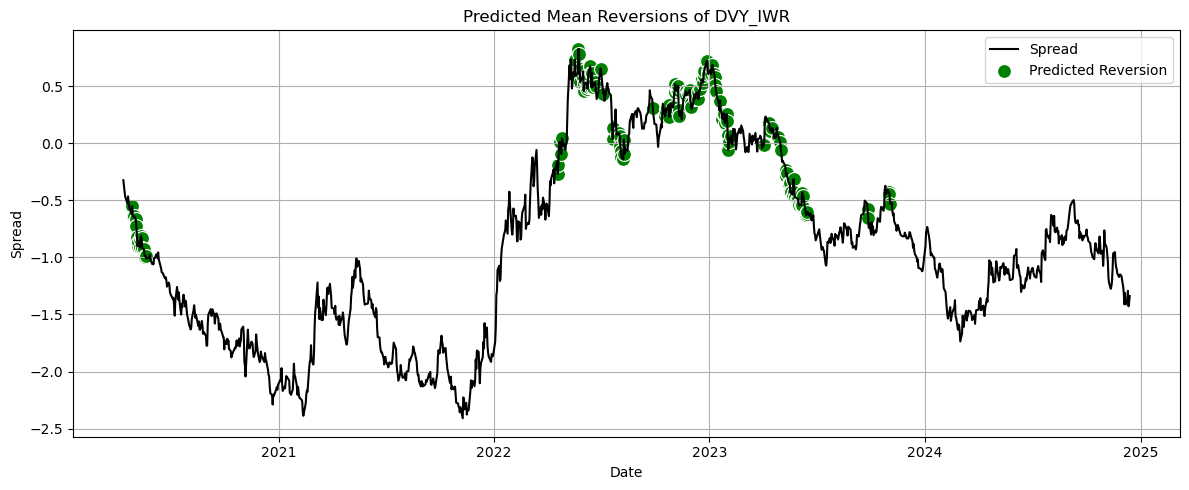

Confusion Matrix:
[[736 108]
 [285  49]]
F1 Score: 0.1996

Training model for pair: SCHV_SPHQ
Epoch 1/20 - Loss: 0.9890
Epoch 2/20 - Loss: 0.9528
Epoch 3/20 - Loss: 0.9259
Epoch 4/20 - Loss: 0.9086
Epoch 5/20 - Loss: 0.8854
Epoch 6/20 - Loss: 0.8716
Epoch 7/20 - Loss: 0.8558
Epoch 8/20 - Loss: 0.8458
Epoch 9/20 - Loss: 0.8302
Epoch 10/20 - Loss: 0.8225
Epoch 11/20 - Loss: 0.8075
Epoch 12/20 - Loss: 0.7843
Epoch 13/20 - Loss: 0.7699
Epoch 14/20 - Loss: 0.7725
Epoch 15/20 - Loss: 0.7683
Epoch 16/20 - Loss: 0.7330
Epoch 17/20 - Loss: 0.6998
Epoch 18/20 - Loss: 0.6943
Epoch 19/20 - Loss: 0.6813
Epoch 20/20 - Loss: 0.6565

Evaluating model for pair: SCHV_SPHQ
Test Accuracy:  0.7130730050933786


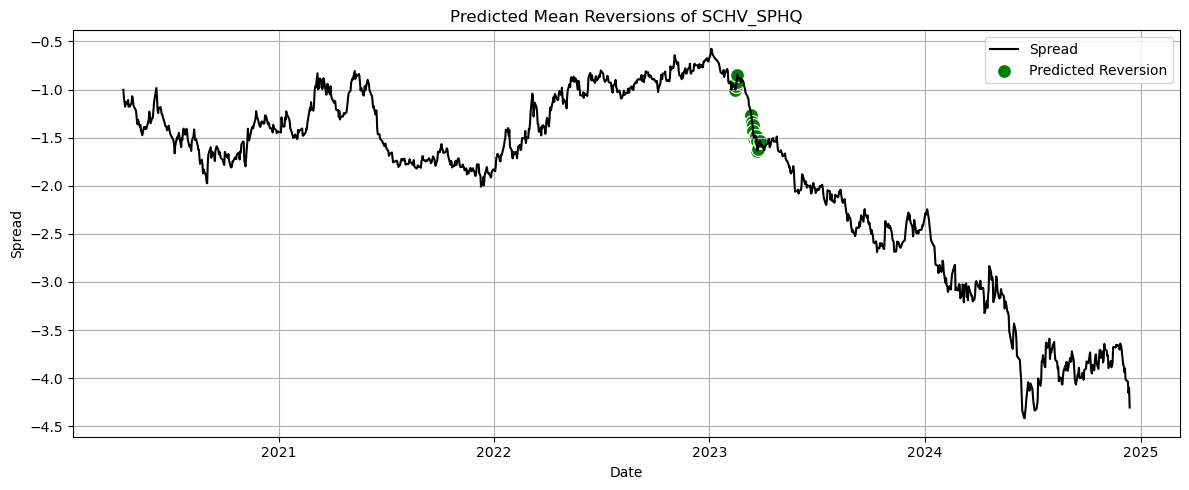

Confusion Matrix:
[[834  11]
 [327   6]]
F1 Score: 0.0343

Training model for pair: IWR_DIA
Epoch 1/20 - Loss: 0.9787
Epoch 2/20 - Loss: 0.9067
Epoch 3/20 - Loss: 0.8705
Epoch 4/20 - Loss: 0.8473
Epoch 5/20 - Loss: 0.8356
Epoch 6/20 - Loss: 0.8158
Epoch 7/20 - Loss: 0.8067
Epoch 8/20 - Loss: 0.8086
Epoch 9/20 - Loss: 0.7840
Epoch 10/20 - Loss: 0.7868
Epoch 11/20 - Loss: 0.7671
Epoch 12/20 - Loss: 0.7836
Epoch 13/20 - Loss: 0.7576
Epoch 14/20 - Loss: 0.7493
Epoch 15/20 - Loss: 0.7249
Epoch 16/20 - Loss: 0.7208
Epoch 17/20 - Loss: 0.7390
Epoch 18/20 - Loss: 0.7295
Epoch 19/20 - Loss: 0.7100
Epoch 20/20 - Loss: 0.7086

Evaluating model for pair: IWR_DIA
Test Accuracy:  0.4779286926994907


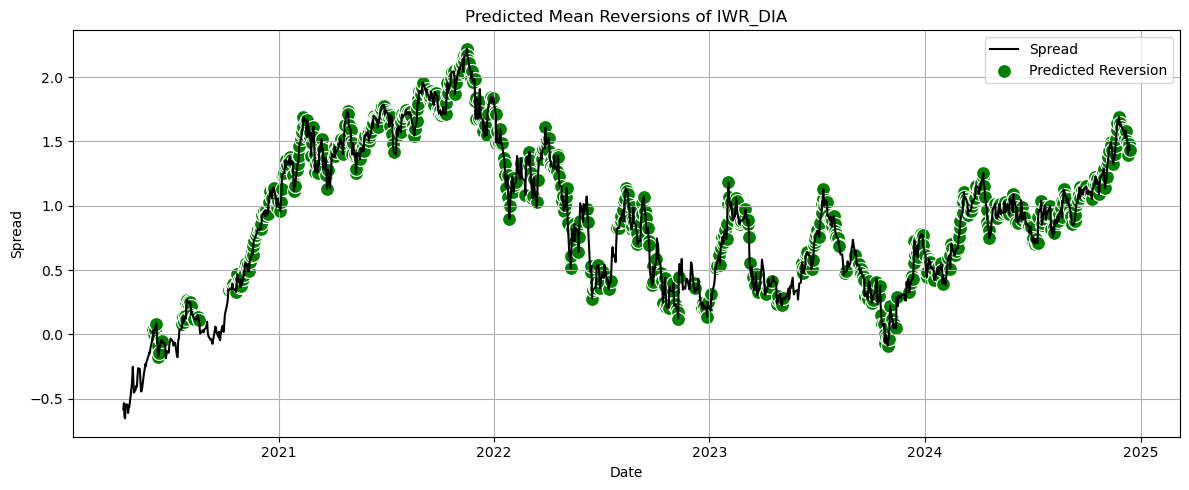

Confusion Matrix:
[[274 573]
 [ 42 289]]
F1 Score: 0.4845

Training model for pair: DVY_OEF
Epoch 1/20 - Loss: 0.9341
Epoch 2/20 - Loss: 0.8980
Epoch 3/20 - Loss: 0.8714
Epoch 4/20 - Loss: 0.8567
Epoch 5/20 - Loss: 0.8344
Epoch 6/20 - Loss: 0.8083
Epoch 7/20 - Loss: 0.7908
Epoch 8/20 - Loss: 0.7773
Epoch 9/20 - Loss: 0.7679
Epoch 10/20 - Loss: 0.7548
Epoch 11/20 - Loss: 0.7409
Epoch 12/20 - Loss: 0.7174
Epoch 13/20 - Loss: 0.7013
Epoch 14/20 - Loss: 0.6788
Epoch 15/20 - Loss: 0.6703
Epoch 16/20 - Loss: 0.6540
Epoch 17/20 - Loss: 0.6616
Epoch 18/20 - Loss: 0.6366
Epoch 19/20 - Loss: 0.6326
Epoch 20/20 - Loss: 0.6032

Evaluating model for pair: DVY_OEF
Test Accuracy:  0.629881154499151


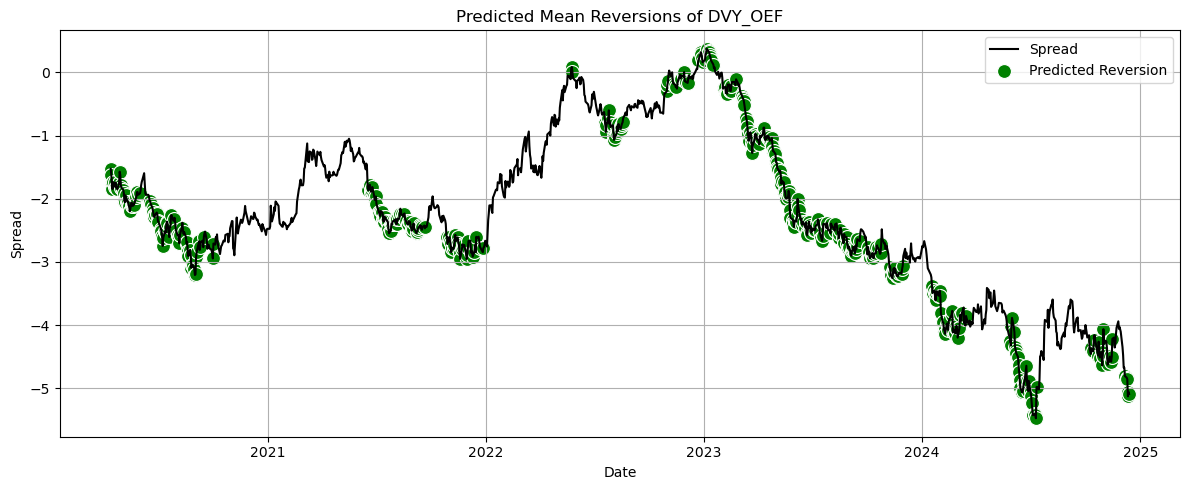

Confusion Matrix:
[[557 292]
 [144 185]]
F1 Score: 0.4591

Training model for pair: VTV_SPHQ
Epoch 1/20 - Loss: 1.0148
Epoch 2/20 - Loss: 0.9585
Epoch 3/20 - Loss: 0.9237
Epoch 4/20 - Loss: 0.8957
Epoch 5/20 - Loss: 0.8712
Epoch 6/20 - Loss: 0.8559
Epoch 7/20 - Loss: 0.8313
Epoch 8/20 - Loss: 0.8253
Epoch 9/20 - Loss: 0.8114
Epoch 10/20 - Loss: 0.7946
Epoch 11/20 - Loss: 0.7735
Epoch 12/20 - Loss: 0.7832
Epoch 13/20 - Loss: 0.7675
Epoch 14/20 - Loss: 0.7485
Epoch 15/20 - Loss: 0.7286
Epoch 16/20 - Loss: 0.7058
Epoch 17/20 - Loss: 0.6919
Epoch 18/20 - Loss: 0.6805
Epoch 19/20 - Loss: 0.6809
Epoch 20/20 - Loss: 0.6610

Evaluating model for pair: VTV_SPHQ
Test Accuracy:  0.6612903225806451


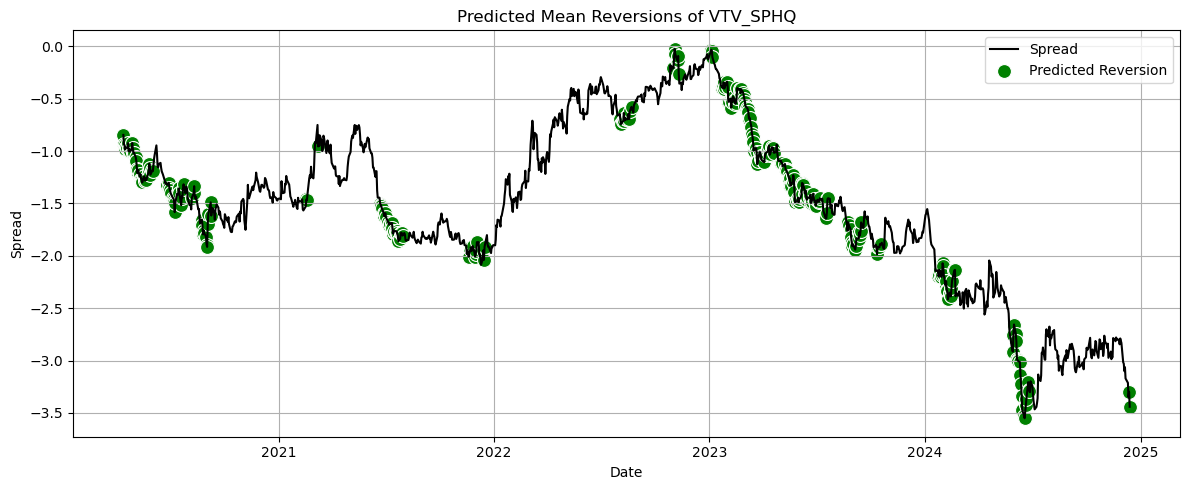

Confusion Matrix:
[[655 188]
 [211 124]]
F1 Score: 0.3833

Training model for pair: RSP_DIA
Epoch 1/20 - Loss: 0.9550
Epoch 2/20 - Loss: 0.8884
Epoch 3/20 - Loss: 0.8562
Epoch 4/20 - Loss: 0.8244
Epoch 5/20 - Loss: 0.8005
Epoch 6/20 - Loss: 0.7850
Epoch 7/20 - Loss: 0.7745
Epoch 8/20 - Loss: 0.7580
Epoch 9/20 - Loss: 0.7510
Epoch 10/20 - Loss: 0.7335
Epoch 11/20 - Loss: 0.7290
Epoch 12/20 - Loss: 0.7217
Epoch 13/20 - Loss: 0.6938
Epoch 14/20 - Loss: 0.6749
Epoch 15/20 - Loss: 0.6872
Epoch 16/20 - Loss: 0.6786
Epoch 17/20 - Loss: 0.6448
Epoch 18/20 - Loss: 0.6415
Epoch 19/20 - Loss: 0.6244
Epoch 20/20 - Loss: 0.6011

Evaluating model for pair: RSP_DIA
Test Accuracy:  0.629881154499151


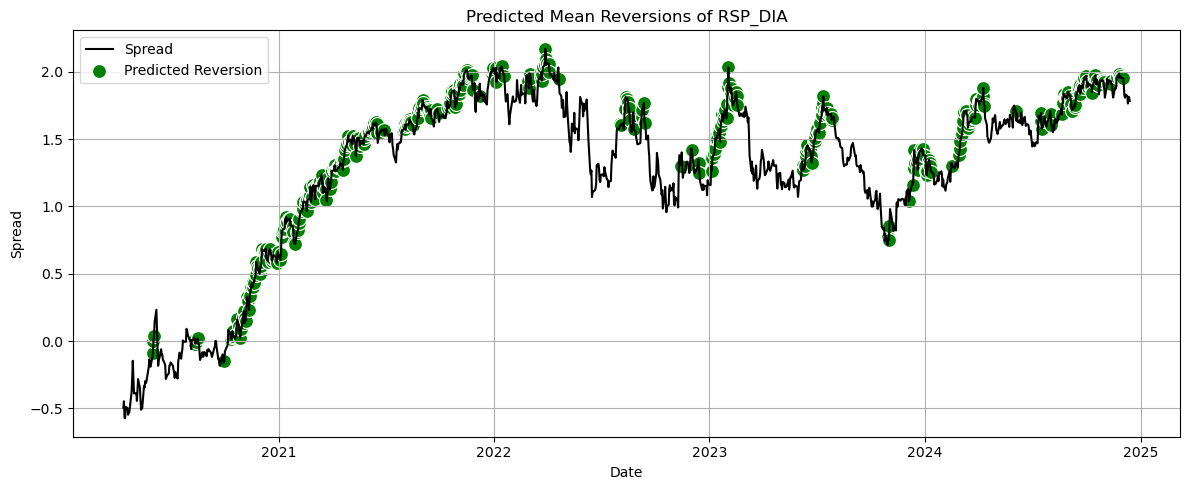

Confusion Matrix:
[[568 286]
 [150 174]]
F1 Score: 0.4439

Training model for pair: VO_DIA
Epoch 1/20 - Loss: 0.9690
Epoch 2/20 - Loss: 0.8851
Epoch 3/20 - Loss: 0.8446
Epoch 4/20 - Loss: 0.8249
Epoch 5/20 - Loss: 0.8305
Epoch 6/20 - Loss: 0.8041
Epoch 7/20 - Loss: 0.7984
Epoch 8/20 - Loss: 0.7768
Epoch 9/20 - Loss: 0.7659
Epoch 10/20 - Loss: 0.7535
Epoch 11/20 - Loss: 0.7499
Epoch 12/20 - Loss: 0.7366
Epoch 13/20 - Loss: 0.7196
Epoch 14/20 - Loss: 0.7015
Epoch 15/20 - Loss: 0.7224
Epoch 16/20 - Loss: 0.6821
Epoch 17/20 - Loss: 0.6611
Epoch 18/20 - Loss: 0.6503
Epoch 19/20 - Loss: 0.6236
Epoch 20/20 - Loss: 0.6395

Evaluating model for pair: VO_DIA
Test Accuracy:  0.46604414261460103


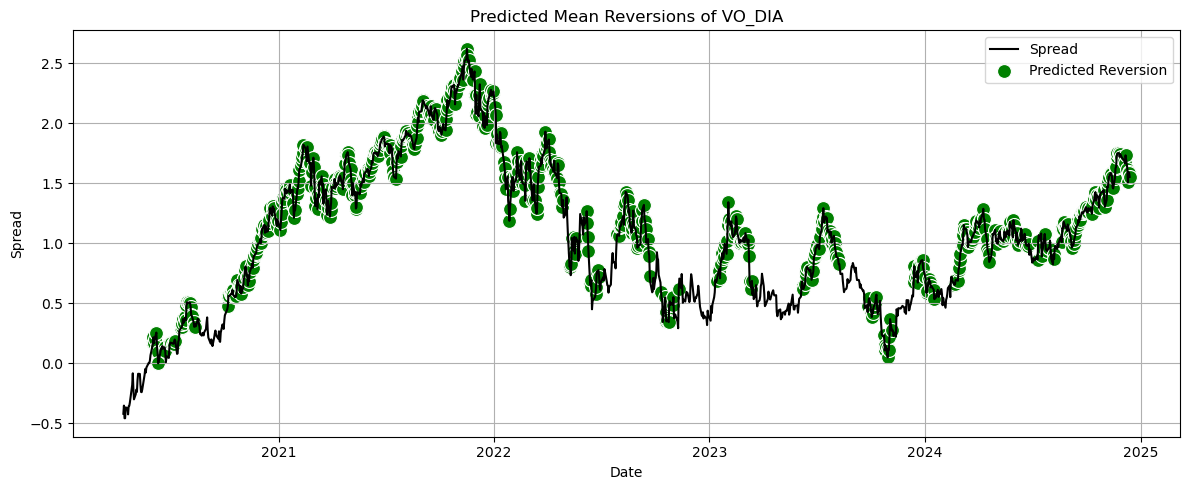

Confusion Matrix:
[[304 547]
 [ 82 245]]
F1 Score: 0.4379

Training model for pair: DVY_FVD
Epoch 1/20 - Loss: 0.9771
Epoch 2/20 - Loss: 0.9391
Epoch 3/20 - Loss: 0.9233
Epoch 4/20 - Loss: 0.9033
Epoch 5/20 - Loss: 0.8855
Epoch 6/20 - Loss: 0.8683
Epoch 7/20 - Loss: 0.8541
Epoch 8/20 - Loss: 0.8462
Epoch 9/20 - Loss: 0.8332
Epoch 10/20 - Loss: 0.8213
Epoch 11/20 - Loss: 0.8113
Epoch 12/20 - Loss: 0.7964
Epoch 13/20 - Loss: 0.7806
Epoch 14/20 - Loss: 0.7757
Epoch 15/20 - Loss: 0.7526
Epoch 16/20 - Loss: 0.7319
Epoch 17/20 - Loss: 0.7250
Epoch 18/20 - Loss: 0.7457
Epoch 19/20 - Loss: 0.7258
Epoch 20/20 - Loss: 0.7094

Evaluating model for pair: DVY_FVD
Test Accuracy:  0.6273344651952462


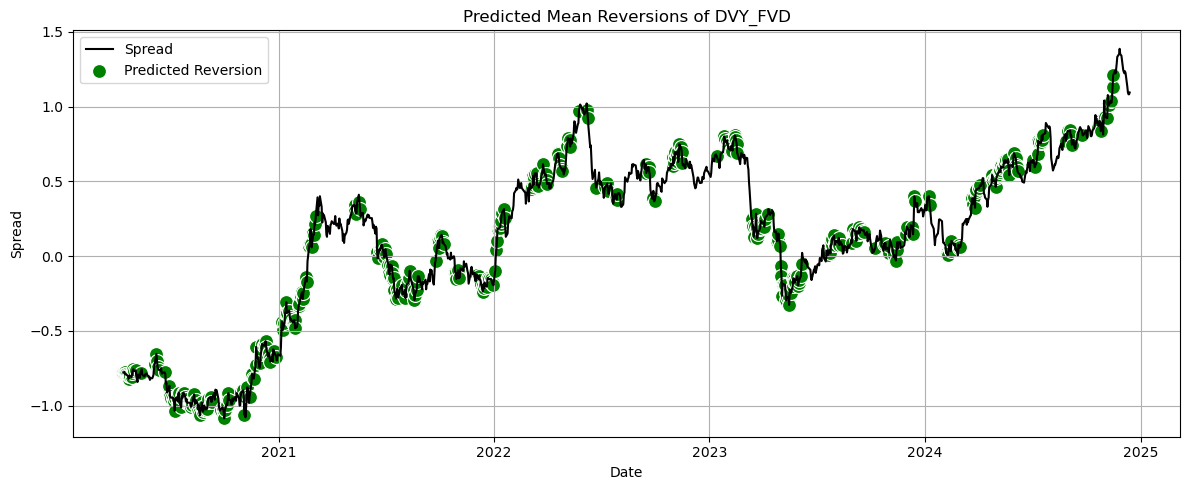

Confusion Matrix:
[[541 292]
 [147 198]]
F1 Score: 0.4743

Training model for pair: DVY_VYM
Epoch 1/20 - Loss: 0.9605
Epoch 2/20 - Loss: 0.9112
Epoch 3/20 - Loss: 0.8862
Epoch 4/20 - Loss: 0.8652
Epoch 5/20 - Loss: 0.8409
Epoch 6/20 - Loss: 0.8230
Epoch 7/20 - Loss: 0.8038
Epoch 8/20 - Loss: 0.7909
Epoch 9/20 - Loss: 0.7686
Epoch 10/20 - Loss: 0.7479
Epoch 11/20 - Loss: 0.7322
Epoch 12/20 - Loss: 0.7087
Epoch 13/20 - Loss: 0.6931
Epoch 14/20 - Loss: 0.6656
Epoch 15/20 - Loss: 0.6553
Epoch 16/20 - Loss: 0.6714
Epoch 17/20 - Loss: 0.6326
Epoch 18/20 - Loss: 0.6145
Epoch 19/20 - Loss: 0.5681
Epoch 20/20 - Loss: 0.5344

Evaluating model for pair: DVY_VYM
Test Accuracy:  0.634125636672326


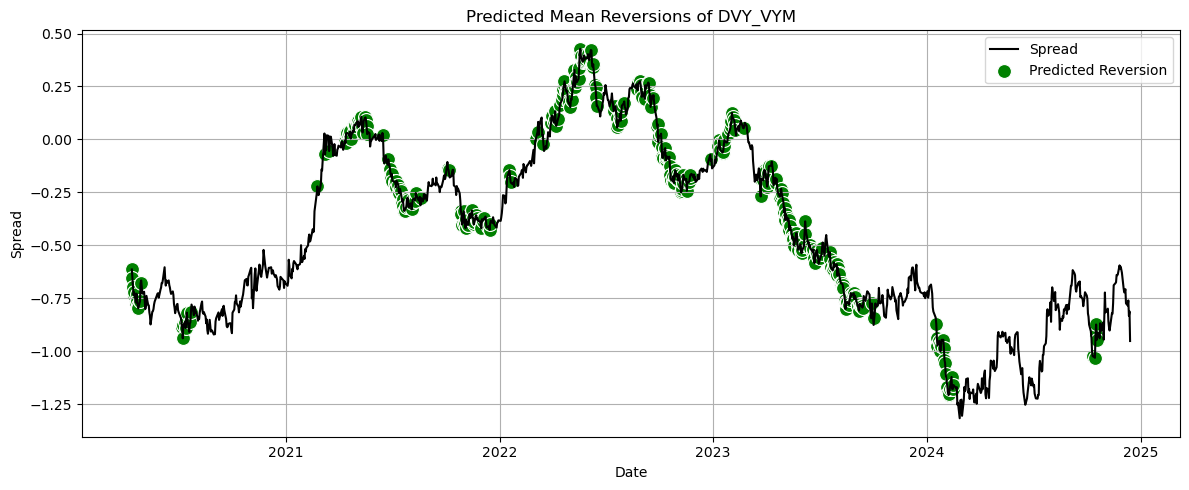

Confusion Matrix:
[[605 251]
 [180 142]]
F1 Score: 0.3972
{'VO_IWB': {'model': ClassificationLSTM(
  (lstm): LSTM(8, 32, batch_first=True)
  (linear): Linear(in_features=32, out_features=1, bias=True)
), 'y_true': array([[1.],
       [0.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]], shape=(1178, 1), dtype=float32), 'y_pred': array([0.0228612 , 0.01131632, 0.00761337, ..., 0.0228481 , 0.02181383,
       0.00976796], shape=(1178,), dtype=float32)}, 'VO_SPY': {'model': ClassificationLSTM(
  (lstm): LSTM(8, 32, batch_first=True)
  (linear): Linear(in_features=32, out_features=1, bias=True)
), 'y_true': array([[1.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]], shape=(1178, 1), dtype=float32), 'y_pred': array([0.00786538, 0.00516174, 0.00339577, ..., 0.00213013, 0.0029979 ,
       0.00329467], shape=(1178,), dtype=float32)}, 'VO_SCHX': {'model': ClassificationLSTM(
  (lstm): LSTM(8, 32, batch_first=True)
  (linear): Linear(in_features=32,

In [11]:
results = {}

for pair_name in training_spreads_df.columns:
    model, y_true, y_pred = run_pair(
        pair_name,
        X_train_dict,
        y_train_dict,
        X_test_dict,
        y_test_dict,
        epochs = 20,
        device = 'cpu'
    )
    results[pair_name] = {'model': model, 'y_true': y_true, 'y_pred': y_pred}

print(results)

In [12]:
def build_prices(pair_list, testing_data, X_test_dict):
    test_prices_dict = {}

    for pair in pair_list:
        etf1, etf2 = pair.split('_')

        price_df = testing_data[[etf1, etf2]].copy()
        price_df.columns = ['price_long', 'price_short']

        test_index = X_test_dict[pair].index
        aligned_prices = price_df.loc[test_index]

        test_prices_dict[pair] = aligned_prices

    return test_prices_dict

In [13]:
def compute_max_drawdown(equity_curve):
    running_max = equity_curve.cummax()
    drawdowns = equity_curve / running_max - 1.0
    max_drawdown = drawdowns.min()
    
    return max_drawdown, drawdowns

In [14]:
def plot_combined_equity_and_drawdown(equity):
    peak = equity.cummax()
    drawdown = (equity - peak) / peak

    fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
    ax[0].plot(equity, label='Combined Equity')
    ax[0].set_title("Combined Equity Curve")
    ax[0].legend()
    ax[0].grid()

    ax[1].plot(drawdown, color='red', label='Drawdown')
    ax[1].set_title("Drawdown Over Time")
    ax[1].legend()
    ax[1].grid()

    plt.tight_layout()
    plt.show()


In [15]:
def simulate_portfolio(
    X_df, probs, y_pred_label, prices_df,
    initial_cash_per_pair = 100.0,
    holding_period = 10,
    entry_threshold = 0.8,
):
    df = X_df.copy()
    df = df.iloc[-len(y_pred_label):].copy()

    df['prob'] = probs
    df['label'] = y_pred_label
    df = df.join(prices_df)

    # print(np.min(probs), np.max(probs), np.mean(probs))

    prob_threshold = np.quantile(probs, 0.85)

    cash = initial_cash_per_pair
    equity = pd.Series(index = df.index, dtype = float)
    equity.iloc[0] = cash
    trades = []

    i = 0
    n = len(df)

    while i < n - holding_period:
        row = df.iloc[i]
        prob = row['prob']
        zscore = row['z-score']
        price_long_in = row['price_long']
        price_short_in = row['price_short']

        if (prob >= prob_threshold and abs(zscore) >= entry_threshold):
            entry_idx = i
            exit_idx = i + holding_period
            entry_date = df.index[entry_idx]
            exit_date = df.index[exit_idx]

            price_long_out = df.iloc[exit_idx]['price_long']
            price_short_out = df.iloc[exit_idx]['price_short']

            notional = cash
            long_dollars, short_dollars = notional / 2.0, notional / 2.0

            if zscore > 0:
                shares_short_long = short_dollars / price_long_in
                shares_long_short = long_dollars / price_short_in

                pnl = (shares_long_short * (price_short_out - price_short_in)) + \
                      (shares_short_long * (price_long_in - price_long_out))
                direction = "Short ETF1 / Long ETF2"
            else:
                shares_long_long = long_dollars / price_long_in
                shares_short_short = short_dollars / price_short_in

                pnl = (shares_long_long * (price_long_out - price_long_in)) + \
                      (shares_short_short * (price_short_in - price_short_out))
                direction = "Long ETF1 / Short ETF2"

            cash += pnl
            equity.loc[exit_date] = cash

            trades.append({
                "entry_date": entry_date,
                "exit_date": exit_date,
                "prob": prob,
                "direction": direction,
                "pnl": pnl,
                "notional": notional
            })

            i = exit_idx + 1
        else:
            equity.iloc[i] = cash
            i += 1

    equity.ffill(inplace = True)
    return equity, trades

In [16]:
def run_simulation(results, X_test_dict, testing_data):
    pair_list = list(X_test_dict.keys())
    test_prices_dict = build_prices(pair_list, testing_data, X_test_dict)

    total_cash = 0
    combined_equity = pd.Series(dtype=float)
    pair_trade_counts = {}
    pair_pnls = {}
    pair_sharpes = {}
    pair_drawdowns = {}
    pair_equities = {}

    plt.figure(figsize=(12, 6))

    for pair_name in pair_list:
        model_info = results[pair_name]
        model = model_info['model']
        y_true = model_info['y_true']
        y_pred = model_info['y_pred']

        probs = torch.sigmoid(torch.tensor(y_pred)).squeeze().numpy()
        y_pred_label = (probs > 0.5).astype(int)

        prices_df = test_prices_dict[pair_name]
        X_test_df = X_test_dict[pair_name]

        equity, trades = simulate_portfolio(X_test_df, probs, y_pred_label, prices_df)

        pair_equities[pair_name] = equity
        max_dd, _ = compute_max_drawdown(equity)
        pair_drawdowns[pair_name] = max_dd

        pair_returns = equity.pct_change().dropna()

        if pair_returns.std() != 0:
            sharpe = (pair_returns.mean() / pair_returns.std()) * np.sqrt(252)
        else:
            sharpe = np.nan

        pair_sharpes[pair_name] = sharpe

        total_cash += equity.iloc[-1]
        pair_trade_counts[pair_name] = len(trades)
        pair_pnls[pair_name] = [t['pnl'] for t in trades]

        if combined_equity.empty:
            equity.name = pair_name
            combined_equity = equity.to_frame()
        else:
            equity.name = pair_name
            combined_equity = pd.concat([combined_equity, equity], axis=1)

        sns.lineplot(x = equity.index, y = equity.values, label = pair_name)

    combined_equity = combined_equity.fillna(method='ffill').fillna(method='bfill')
    combined_equity['Total'] = combined_equity.sum(axis=1)

    plt.title("LSTM Equity Curve by Pair", fontsize=15, weight='bold')
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Portfolio Value ($)", fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"\nFinal Portfolio Value: ${total_cash:,.2f}")
    print("\nTrade Summary:")
    for pair, count in pair_trade_counts.items():
        total_pnl = sum(pair_pnls[pair])
        avg_pnl = np.mean(pair_pnls[pair]) if pair_pnls[pair] else 0
        print(f"  {pair}: {count} trades | Total PnL: ${total_pnl:.2f} | Avg PnL: ${avg_pnl:.2f}")

    yearly = combined_equity.resample('YE').last()
    print("\nYear-End Portfolio Values:")
    print(yearly)

    print("\nSharpe Ratios by Pair:")
    for pair, sharpe in pair_sharpes.items():
        print(f"{pair}: Sharpe Ratio = {sharpe:.2f}")

    combined_returns = combined_equity['Total'].pct_change().dropna()
    sharpe_ratio = (combined_returns.mean() / combined_returns.std()) * np.sqrt(252)
    print(f"\nTotal Sharpe Ratio: {sharpe_ratio:.2f}")

    print("\nMax Drawdowns by Pair:")
    for pair, drawdown in pair_drawdowns.items():
        print(f"{pair}: Max Drawdown = {drawdown:.2%}")

    max_dd, drawdowns = compute_max_drawdown(combined_equity['Total'])
    print(f"\nTotal Max Drawdown: {max_dd:.2%}")

    plot_combined_equity_and_drawdown(combined_equity['Total'])

    for pair in combined_equity.columns:
        print(f"Pair: {pair}")
        print(combined_equity[pair].tail(10))  # show last 10 rows for this pair
        print("-" * 40)

    cumulative_equity = combined_equity['Total']
    cumulative_equity.to_csv("equity_curves/lstm_equity.csv", header = ["Portfolio Value"])

/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_6441/579190202.py:55: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_equity = combined_equity.fillna(method='ffill').fillna(method='bfill')


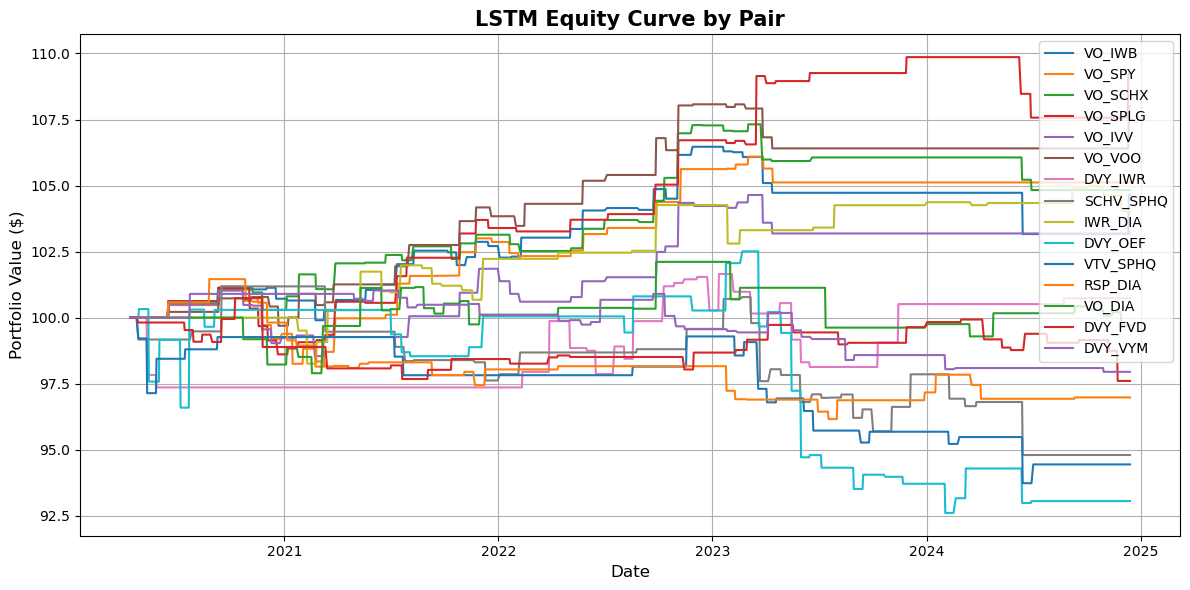


Final Portfolio Value: $1,514.32

Trade Summary:
  VO_IWB: 36 trades | Total PnL: $4.66 | Avg PnL: $0.13
  VO_SPY: 32 trades | Total PnL: $5.12 | Avg PnL: $0.16
  VO_SCHX: 36 trades | Total PnL: $4.83 | Avg PnL: $0.13
  VO_SPLG: 34 trades | Total PnL: $9.23 | Avg PnL: $0.27
  VO_IVV: 28 trades | Total PnL: $3.19 | Avg PnL: $0.11
  VO_VOO: 31 trades | Total PnL: $8.01 | Avg PnL: $0.26
  DVY_IWR: 25 trades | Total PnL: $0.74 | Avg PnL: $0.03
  SCHV_SPHQ: 33 trades | Total PnL: $-5.20 | Avg PnL: $-0.16
  IWR_DIA: 29 trades | Total PnL: $4.03 | Avg PnL: $0.14
  DVY_OEF: 33 trades | Total PnL: $-6.95 | Avg PnL: $-0.21
  VTV_SPHQ: 22 trades | Total PnL: $-5.56 | Avg PnL: $-0.25
  RSP_DIA: 30 trades | Total PnL: $-3.02 | Avg PnL: $-0.10
  VO_DIA: 31 trades | Total PnL: $-0.29 | Avg PnL: $-0.01
  DVY_FVD: 36 trades | Total PnL: $-2.40 | Avg PnL: $-0.07
  DVY_VYM: 29 trades | Total PnL: $-2.05 | Avg PnL: $-0.07

Year-End Portfolio Values:
                VO_IWB      VO_SPY     VO_SCHX     VO_S

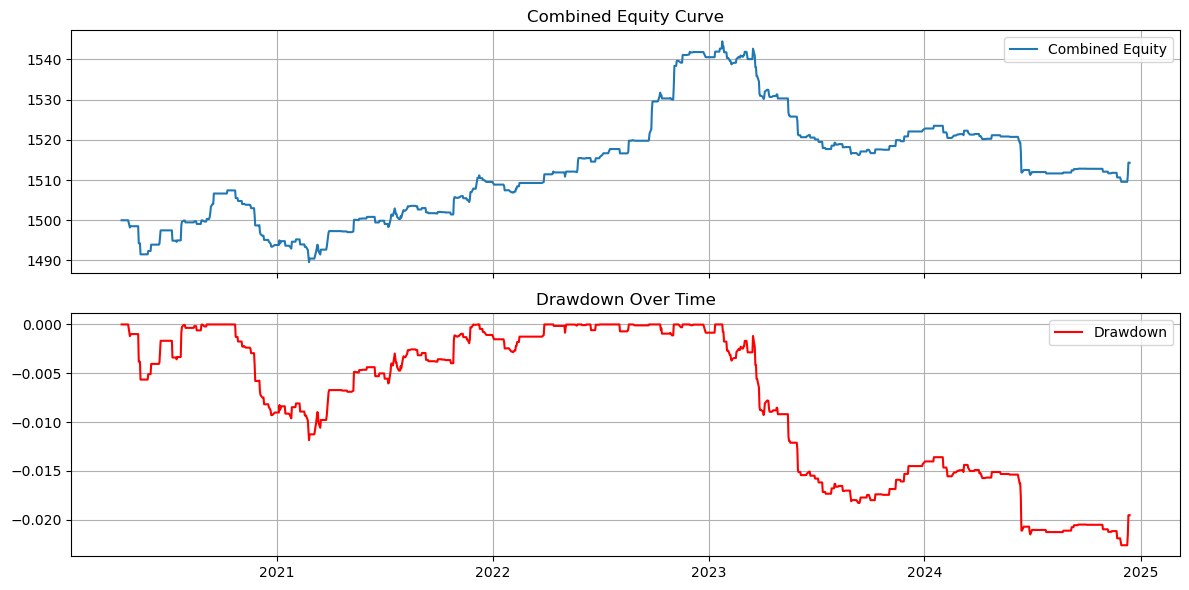

Pair: VO_IWB
Date
2024-12-02    103.163617
2024-12-03    103.163617
2024-12-04    103.163617
2024-12-05    103.163617
2024-12-06    103.163617
2024-12-09    103.163617
2024-12-10    103.163617
2024-12-11    104.655135
2024-12-12    104.655135
2024-12-13    104.655135
Name: VO_IWB, dtype: float64
----------------------------------------
Pair: VO_SPY
Date
2024-12-02    105.117472
2024-12-03    105.117472
2024-12-04    105.117472
2024-12-05    105.117472
2024-12-06    105.117472
2024-12-09    105.117472
2024-12-10    105.117472
2024-12-11    105.117472
2024-12-12    105.117472
2024-12-13    105.117472
Name: VO_SPY, dtype: float64
----------------------------------------
Pair: VO_SCHX
Date
2024-12-02    104.829089
2024-12-03    104.829089
2024-12-04    104.829089
2024-12-05    104.829089
2024-12-06    104.829089
2024-12-09    104.829089
2024-12-10    104.829089
2024-12-11    104.829089
2024-12-12    104.829089
2024-12-13    104.829089
Name: VO_SCHX, dtype: float64
-------------------------

In [17]:
run_simulation(results, X_test_dict, testing_data)